In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures

In [2]:
import matplotlib.pyplot as plt

In [7]:
df_warbl = pd.read_csv('./warblrb10k_public_wav/labels.csv')
df_ff101 = pd.read_csv('./ff1010bird_wav/labels.csv')

In [8]:
print(df_warbl.head())

                    itemid  hasbird
0  759808e5-f824-401e-9058        1
1  1d94fc4a-1c63-4da0-9cac        1
2  bb0099ce-3073-4613-8557        1
3  c4c67e81-9aa8-4af4-8eb7        1
4  ab322d4b-da69-4b06-a065        0


In [9]:
print(df_ff101.head())

   itemid  hasbird
0   64486        0
1    2525        0
2   44981        0
3  101323        0
4  165746        0


In [10]:
df_warbl['itemid'] = ['./../warblrb10k_public_wav/wav/' + f+'.wav' for f in df_warbl.itemid]
df_ff101['itemid'] = ['./../ff1010bird_wav/wav/' + str(f)+'.wav' for f in df_ff101.itemid]
print(df_warbl.head())
print(df_ff101.head())

                                              itemid  hasbird
0  ./../warblrb10k_public_wav/wav/759808e5-f824-4...        1
1  ./../warblrb10k_public_wav/wav/1d94fc4a-1c63-4...        1
2  ./../warblrb10k_public_wav/wav/bb0099ce-3073-4...        1
3  ./../warblrb10k_public_wav/wav/c4c67e81-9aa8-4...        1
4  ./../warblrb10k_public_wav/wav/ab322d4b-da69-4...        0
                               itemid  hasbird
0   ./../ff1010bird_wav/wav/64486.wav        0
1    ./../ff1010bird_wav/wav/2525.wav        0
2   ./../ff1010bird_wav/wav/44981.wav        0
3  ./../ff1010bird_wav/wav/101323.wav        0
4  ./../ff1010bird_wav/wav/165746.wav        0


In [11]:
df = pd.concat([df_ff101, df_warbl])
df.shape

(15690, 2)

In [12]:
df['hasbird'].value_counts()

1    7980
0    7710
Name: hasbird, dtype: int64

In [ ]:
from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(df[['hasbird']].values)
labels = pd.DataFrame(index=df['itemid'],data=one_hot_labels,columns=classes)
labels.rename(columns={0: "empty", 1: "non-empty"}, inplace=True)
print(labels['empty'].value_counts())

In [ ]:
from sklearn.model_selection import train_test_split
# train_df, test_df = train_test_split(labels, test_size=0.2, random_state=1)
train_df, valid_df = train_test_split(labels, test_size=0.2, random_state=1)

In [ ]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

train_dataset = CnnPreprocessor(train_df)
train_dataset.augmentation_on()
train_dataset.actions.load_audio.set(sample_rate=44100)

valid_dataset = CnnPreprocessor(valid_df)
valid_dataset.augmentation_on()
valid_dataset.actions.load_audio.set(sample_rate=44100)

In [ ]:
classes = train_df.columns
model = cnn.PytorchModel('resnet18',classes,single_target=True)

In [ ]:
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./microfaune_resnet18_train_augmentation_on/',
    epochs=12,
    batch_size=64,
    save_interval=100,
    num_workers=2,
)

In [ ]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('model_loss.png')

In [3]:
from opensoundscape.torch.models.cnn import load_model
model = load_model('./microfaune_resnet18_train_augmentation_on/best.model')

In [4]:
df_test = pd.read_csv('peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/Copy of Stratified_Random_Sample_Bird_Labels.csv')
df_test['Filename'] = './peru_data/Audiomoth_Madre_de_Dios_Field_Recordings/All/' + df_test['Folder'] + '/' + df_test['Clip']
df_test.drop(columns=['Folder', 'Clip'], inplace=True)

In [5]:
from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(df_test[['Bird(s)?']].values)
test_data = pd.DataFrame(index=df_test['Filename'],data=one_hot_labels,columns=classes)
print(test_data.head())
test_data.rename(columns={"y": "non-empty", "n": "empty"}, inplace=True)
test_data = test_data[['empty', 'non-empty']]
test_data.shape
cols=[i for i in test_data.columns if i not in ["file"]]
for col in cols:
    test_data[col]=pd.to_numeric(test_data[col])

                                                    n  y
Filename                                                
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  0  1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  1  0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  1  0
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  0  1
./peru_data/Audiomoth_Madre_de_Dios_Field_Recor...  0  1


In [6]:
test_data['empty'].value_counts()

1    4007
0    3113
Name: empty, dtype: int64

In [7]:
#create a copy of the training dataset, sampling 0 of the training samples from it
prediction_dataset = model.train_dataset.sample(n=0)
#turn off augmentation on this dataset
prediction_dataset.augmentation_off()
#use the validation samples as test samples for the sake of illustration
prediction_dataset.df = test_data

In [8]:
prediction_dataset.df.columns

Index(['empty', 'non-empty'], dtype='object')

In [9]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 activation_layer='softmax')

(7120, 2)


In [10]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74      4007
           1       0.66      0.63      0.65      3113

   micro avg       0.70      0.70      0.70      7120
   macro avg       0.69      0.69      0.69      7120
weighted avg       0.70      0.70      0.70      7120
 samples avg       0.70      0.70      0.70      7120



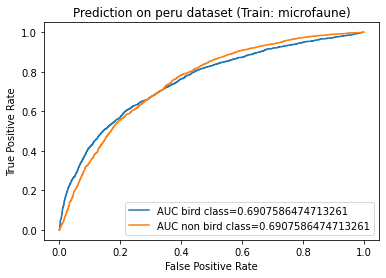

In [12]:
fpr, tpr, thresh = roc_curve(valid_labels_df['non-empty'],  valid_scores_df['non-empty'])
auc = roc_auc_score(valid_labels_df['non-empty'],  valid_preds_df['non-empty'])

fpr2, tpr2, thresh2 = roc_curve(valid_labels_df['empty'],  valid_scores_df['empty'])
auc2 = roc_auc_score(valid_labels_df['empty'],  valid_preds_df['empty'])

#create ROC curve
plt.plot(fpr,tpr,label="AUC bird class="+str(auc))
plt.title('Prediction on peru dataset (Train: microfaune)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.plot(fpr2, tpr2,label="AUC non bird class="+str(auc2))
plt.legend(loc=4)
plt.savefig('./microfaune_resnet18_train_augmentation_on/AUC_curve_peru_MicroFaune.jpg', format='jpg', transparent=False)